In [4]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [5]:
%pycodestyle_on

### Walkthrough for creating a model 4-Gaussian trace profile on the 2D NIRISS detector. Functions are stored in ModelTraceto2DMap.py

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from tqdm import tqdm
import ModelTraceto2DMap as mt
import warnings
# import sys
# sys.path.insert(1, '/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/trace/')
# import tracepol as tp

warnings.filterwarnings("ignore")

9:80: E501 line too long (82 > 79 characters)
9:80: E501 line too long (82 > 79 characters)


### Create an example rectified trace, with no spectral dependence and random parameters

100%|██████████| 2048/2048 [00:00<00:00, 2304.95it/s]


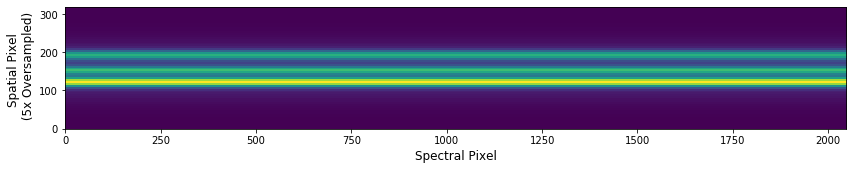

In [7]:
# Randomly choose amplitudes, widths and means for the four Gaussians
amp, pos, wid = [0.006, 0.006, 0.01, 0.002], [30, 38, 24, 30], \
    [1.6, 1.6, 1.6, 9]

# construct_model_4G creates the horned trace profile
G4mod = mt.construct_model_4G(amp, pos, wid)

# make_rectified_trace broadcasts the trace profile across the spectral axis
rectr = mt.make_rectified_trace(G4mod, np.arange(64), os=5)

# Plot the results
fig = plt.figure(figsize=(14, 17))
plt.imshow(rectr)
plt.xlabel('Spectral Pixel', fontsize=12)
plt.ylabel('Spatial Pixel \n (5x Oversampled)', fontsize=12)
plt.gca().invert_yaxis()

### Estimate the spectral dependence of the trace from CV3 data

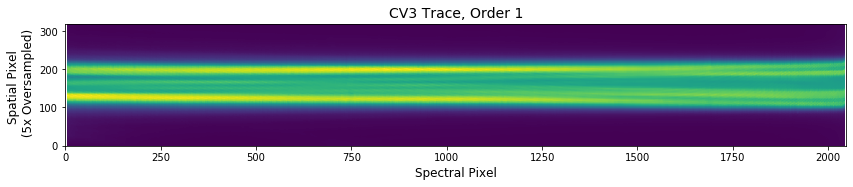

In [8]:
# Load the empirical trace from the CV3 data
a = fits.open('trace_order1.fits')
tracemodel_L = a[0].data
tracemodel_L = np.delete(tracemodel_L, 1, axis=0)
osdimy = a[0].header['OVRSAMPY']
semiwidthy = int((np.shape(tracemodel_L)[0] - 1) / osdimy / 2)

# Plot the CV3 trace for order 1
fig = plt.figure(figsize=(14, 17))
plt.title('CV3 Trace, Order 1', fontsize=14)
plt.imshow(tracemodel_L)
plt.xlabel('Spectral Pixel', fontsize=12)
plt.ylabel('Spatial Pixel \n (5x Oversampled)', fontsize=12)
plt.gca().invert_yaxis()

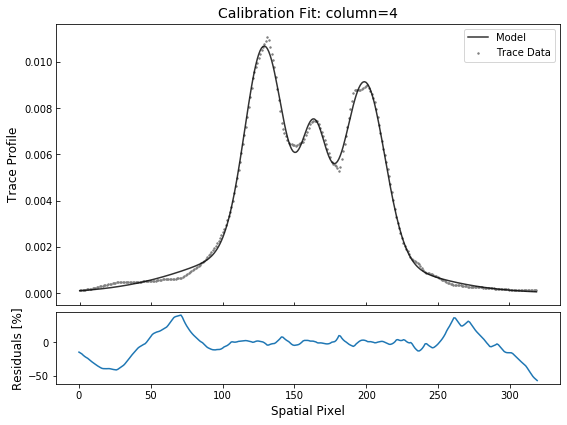

In [9]:
# calibrate_fit determines best guess starting parameters for the full trace
# fit with a calibration fit of the desired trace profile to a single
# detector column.

Amp, Mean, Wid = mt.calibrate_fit(tracemodel_L, plot=True)

100%|██████████| 2040/2040 [06:18<00:00,  5.39it/s]


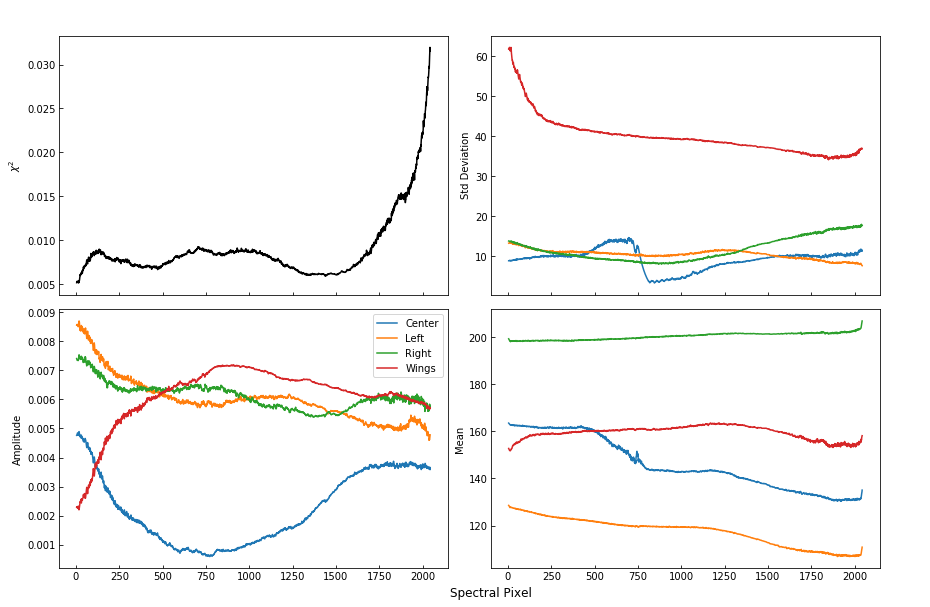

In [10]:
# Fit the 4-Gaussian model to each column in the CV3 trace
specparams = mt.fit_rectrace(tracemodel_L, Amp, Mean, Wid, plot=True)

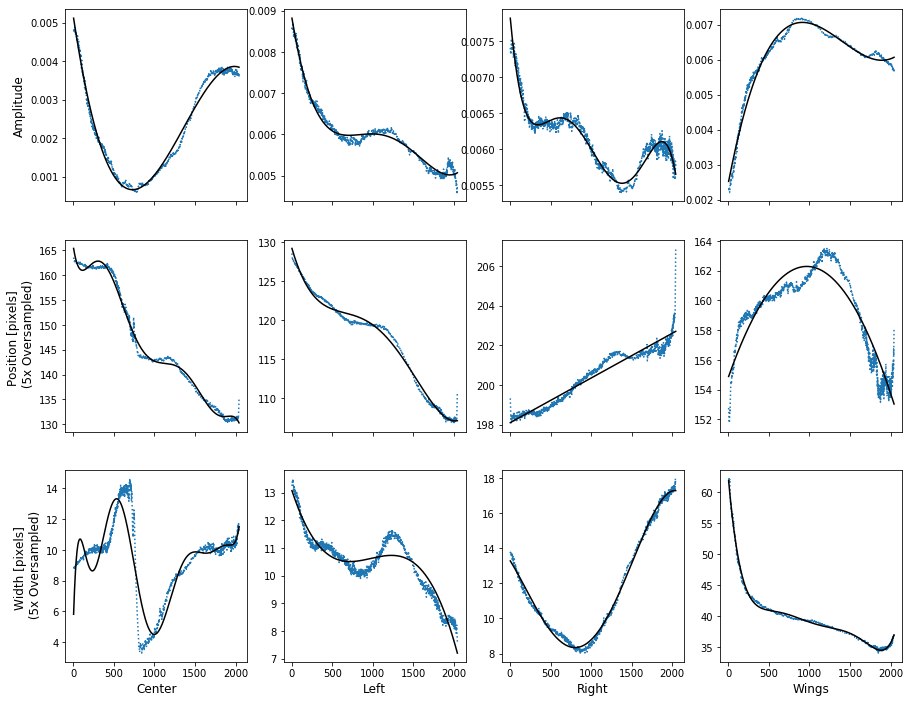

In [11]:
# Fit polynomials to the Gaussian parameter variations
polys = mt.fit_specpoly(specparams, os=5, plot=True)

### Create the new trace model, with spectral dependence

In [12]:
# Create a new rectified trace using the spectal dependencies determined above.
tracemodel_withspec = mt.make_rectified_trace(mt.construct_model_4G,
                                              specparams=polys, os=5)

100%|██████████| 2048/2048 [00:03<00:00, 535.39it/s]


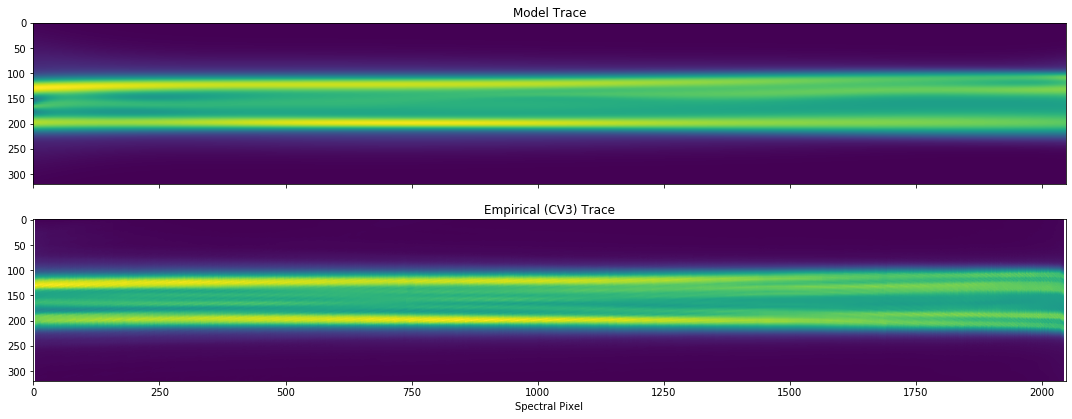

Text(0.5, 1.0, 'Percent Differences')

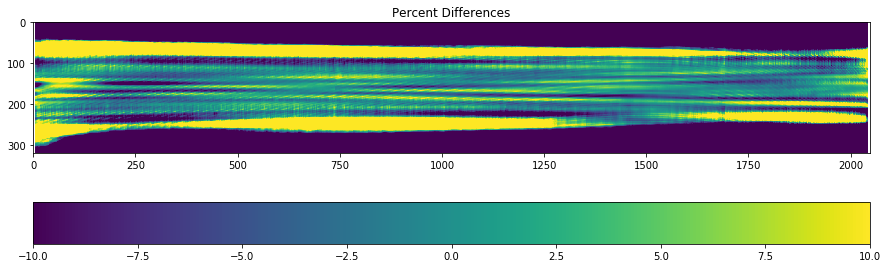

In [13]:
# Plot the model trace and compare with the emprial one.
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)
ax[0].set_title('Model Trace')
ax[0].imshow(tracemodel_withspec)

ax[1].imshow(tracemodel_L)
ax[1].set_title('Empirical (CV3) Trace')
ax[1].set_xlabel('Spectral Pixel')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.imshow(100*(tracemodel_withspec - tracemodel_L)/tracemodel_L,
           vmin=-10, vmax=10)
plt.colorbar(orientation="horizontal")
plt.title('Percent Differences')

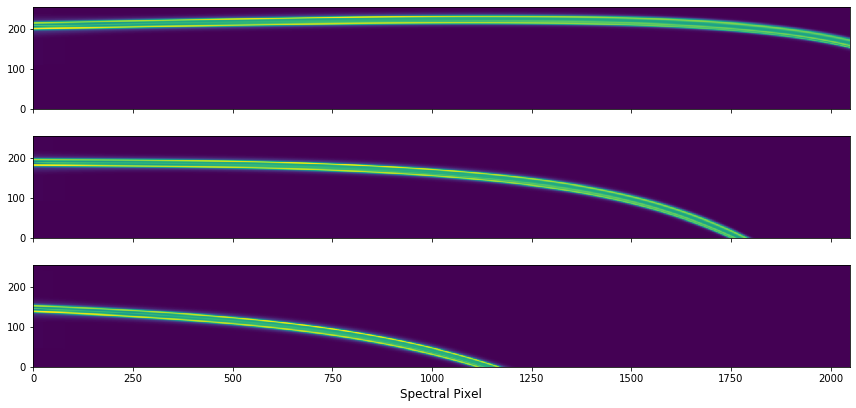

In [14]:
# Example plot of all three orders
ms = [1, 2, 3]

# make_2D_trace creates the full 2D curved SOSS trace using predeterined
# centroid positions. It can also return a fits file datacube with each
# trace order as a frame.

map2D = mt.make_2D_trace(tracemodel_withspec, orders=ms, os=5)

# Plot the results
fig, ax = plt.subplots(nrows=len(ms), ncols=1, figsize=(12, 2*len(ms)),
                       sharex=True)
for m in ms:
    ax[m-1].imshow(map2D[m-1], origin='lower')
plt.xlabel('Spectral Pixel', fontsize=12)
fig.tight_layout()